# Project Final Report

### Due: Midnight on April 27 (2-hour grace period) — 50 points  

### No late submissions will be accepted.


## Overview

Your final submission consists of **three components**:

---

### 1. Final Report Notebook [40 pts]

Complete all sections of this notebook to document your final decisions, results, and broader context.

- **Part A**: Select the single best model from your Milestone 2 experiments. Now that you’ve finalized your model, revisit your decisions from Milestones 1 and 2. Are there any steps you would change—such as cleaning, feature engineering, or model evaluation—given what you now know?

- **Part B**: Write a technical report following standard conventions, for example:
  - [CMU guide to structure](https://www.stat.cmu.edu/~brian/701/notes/paper-structure.pdf)
  - [Data science report example](https://www.projectpro.io/article/data-science-project-report/620)
  - The Checklist given in this week's Blackboard Lesson (essentially the same as in HOML).
    
  Your audience here is technically literate but unfamiliar with your work—like your manager or other data scientists. Be clear, precise, and include both code (for illustration), charts/plots/illustrations, and explanation of what you discovered and your reasoning process. 

The idea here is that Part A would be a repository of the most important code, for further work to come, and Part B is
the technical report which summarizes your project for the data science group at your company. Do NOT assume that readers of Part B are intimately familiar with Part A; provide code for illustration as needed, but not to run.

Submit this notebook as a group via your team leader’s Gradescope account.

---

### 2. PowerPoint Presentation [10 pts]

Create a 10–15 minute presentation designed for a general audience (e.g., sales or marketing team).

- Prepare 8–12 slides, following the general outline of the sections of Part B. 
- Focus on storytelling, visuals (plots and illustrations), and clear, simplified language. No code!
- Use any presentation tool you like, but upload a PDF version.
- List all team members on the first slide.

Submit as a group via your team leader’s Gradescope account.

---

### 3. Individual Assessment

Each team member must complete the Individual Assessment Form (same as in Milestone 1), sign it, and upload it via their own Gradescope account.

---

## Submission Checklist

-  Final Report Notebook — Team leader submission
-  PDF Slides — Team leader submission
-  Individual Assessment Form — Each member submits their own


## Part A: Final Model and Design Reassessment [10 pts]

In this part, you will finalize your best-performing model and revisit earlier decisions to determine if any should be revised in light of your complete modeling workflow. You’ll also consolidate and present the key code used to run your model on the preprocessed dataset, with thoughtful documentation of your reasoning.

**Requirements:**

- Reconsider **at least one decision from Milestone 1** (e.g., preprocessing, feature engineering, or encoding). Explain whether you would keep or revise that decision now that you know which model performs best. Justify your reasoning.
  
- Reconsider **at least one decision from Milestone 2** (e.g., model evaluation, cross-validation strategy, or feature selection). Again, explain whether you would keep or revise your original decision, and why.

- Below, include all code necessary to **run your final model** on the processed dataset. This section should be a clean, readable summary of the most important steps from Milestones 1 and 2, adapted as needed to fit your final model choice and your reconsiderations as just described. 

- Use Markdown cells and inline comments to explain the structure of the code clearly but concisely. The goal is to make your reasoning and process easy to follow for instructors and reviewers.

> Remember: You are not required to change your earlier choices, but you *are* required to reflect on them and justify your final decisions.


## Project Setup: Imports, Configs, and Helper Functions

This section loads all the libraries and settings we'll use throughout the project, grouped by purpose for clarity:

### 1. Standard Libraries  
General utilities for file handling, math, time tracking, and URL parsing (`os`, `time`, `math`, `io`, `zipfile`, `requests`, `urlparse`, `itertools`).

### 2. Data Science Tools  
`pandas`, `numpy` for data wrangling; `seaborn`, `matplotlib` for visualizations.

### 3. Scikit-Learn (ML)  
Covers preprocessing, model evaluation, feature selection, and ensemble models.

### 4. Extras  
`kagglehub` for downloading datasets, `tqdm` for progress bars.

### 5. Global Config  
Sets a random seed (`random_state = 42`) for reproducibility.

### 6. Utility Functions  
- `dollar_format`: formats y-axis ticks as dollar values.  
- `format_hms`: converts seconds into `HH:MM:SS`.

In [1]:
# =============================
# Useful Imports
# =============================

# Standard Libraries
import os
import time
import math
import io
import zipfile
import requests
from urllib.parse import urlparse
from itertools import chain, combinations

# Data Science Libraries
import numpy as np
import pandas as pd
import seaborn as sns

# Visualization
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.ticker as mticker  # Optional: Format y-axis labels as dollars

# Scikit-learn (Machine Learning)
from sklearn.model_selection import (
    train_test_split, 
    cross_val_score, 
    GridSearchCV, 
    RandomizedSearchCV, 
    RepeatedKFold
)
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SequentialFeatureSelector, f_regression, SelectKBest
from sklearn.datasets import make_regression
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, GradientBoostingRegressor

# Kaggle and Progress Tracking
import kagglehub
from tqdm import tqdm

# =============================
# Global Variables
# =============================
random_state = 42

# =============================
# Utility Functions
# =============================

# Format y-axis labels as dollars with commas (optional)
def dollar_format(x, pos):
    return f'${x:,.0f}'

# Convert seconds to HH:MM:SS format
def format_hms(seconds):
    return time.strftime("%H:%M:%S", time.gmtime(seconds))



/usr/local/python/3.12.1/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Data Download & Load

We use `load_zillow_data()` to check if the dataset exists locally, download it if not, and then load it as a DataFrame. It handles errors cleanly and avoids repeated downloads. This keeps our workflow smooth and avoids accidentally hitting the server more than needed.

In [2]:
def load_zillow_data(url: str) -> pd.DataFrame:
    """
    Downloads a CSV file from the given URL if it doesn't exist locally,
    then loads it into a pandas DataFrame.

    Args:
        url (str): URL to the Zillow dataset.

    Returns:
        pd.DataFrame: Loaded dataset.
    """
    filename = os.path.basename(urlparse(url).path)

    if not os.path.exists(filename):
        try:
            print(f"Downloading {filename}...")
            response = requests.get(url)
            response.raise_for_status()
            with open(filename, "wb") as f:
                f.write(response.content)
            print("Download complete.")
        except requests.exceptions.RequestException as e:
            print(f"Failed to download the file: {e}")
            raise

    else:
        print(f"{filename} already exists. Skipping download.")

    return pd.read_csv(filename)

# Example usage
url = "https://www.cs.bu.edu/fac/snyder/cs505/Data/zillow_dataset.csv"
df = load_zillow_data(url)

zillow_dataset.csv already exists. Skipping download.


### Initial Data Exploration

We use the `explore_dataframe` function to understand the structure and quality of the dataset:
- View the first few rows
- Examine column data types and null counts
- Identify unique values per column
- Assess missing data percentages
- Generate summary statistics for numeric features

These steps help define cleaning and transformation strategies in later stages.

In [3]:
def explore_dataframe(df: pd.DataFrame) -> None:
    """
    Display essential exploration metrics for a DataFrame.

    Args:
        df (pd.DataFrame): The dataframe to explore.
    """
    print("First five rows:")
    display(df.head())

    print("\nDataFrame Info:")
    df.info()

    print("\nUnique values per column:")
    display(df.nunique().sort_values(ascending=False))

    print("\nMissing values (%):")
    missing_percent = df.isnull().mean().sort_values(ascending=False) * 100
    display(missing_percent[missing_percent > 0])

    print("\nSummary statistics for numerical columns:")
    summary_stats = df.describe().T
    summary_stats['std'] = summary_stats['std'].sort_values(ascending=False)
    display(summary_stats)

### Visualizing Numeric Distributions

The `plot_numeric_histograms()` function quickly gives us a look at the distribution of all numeric features. This helps spot skew, outliers, and potential candidates for transformation.

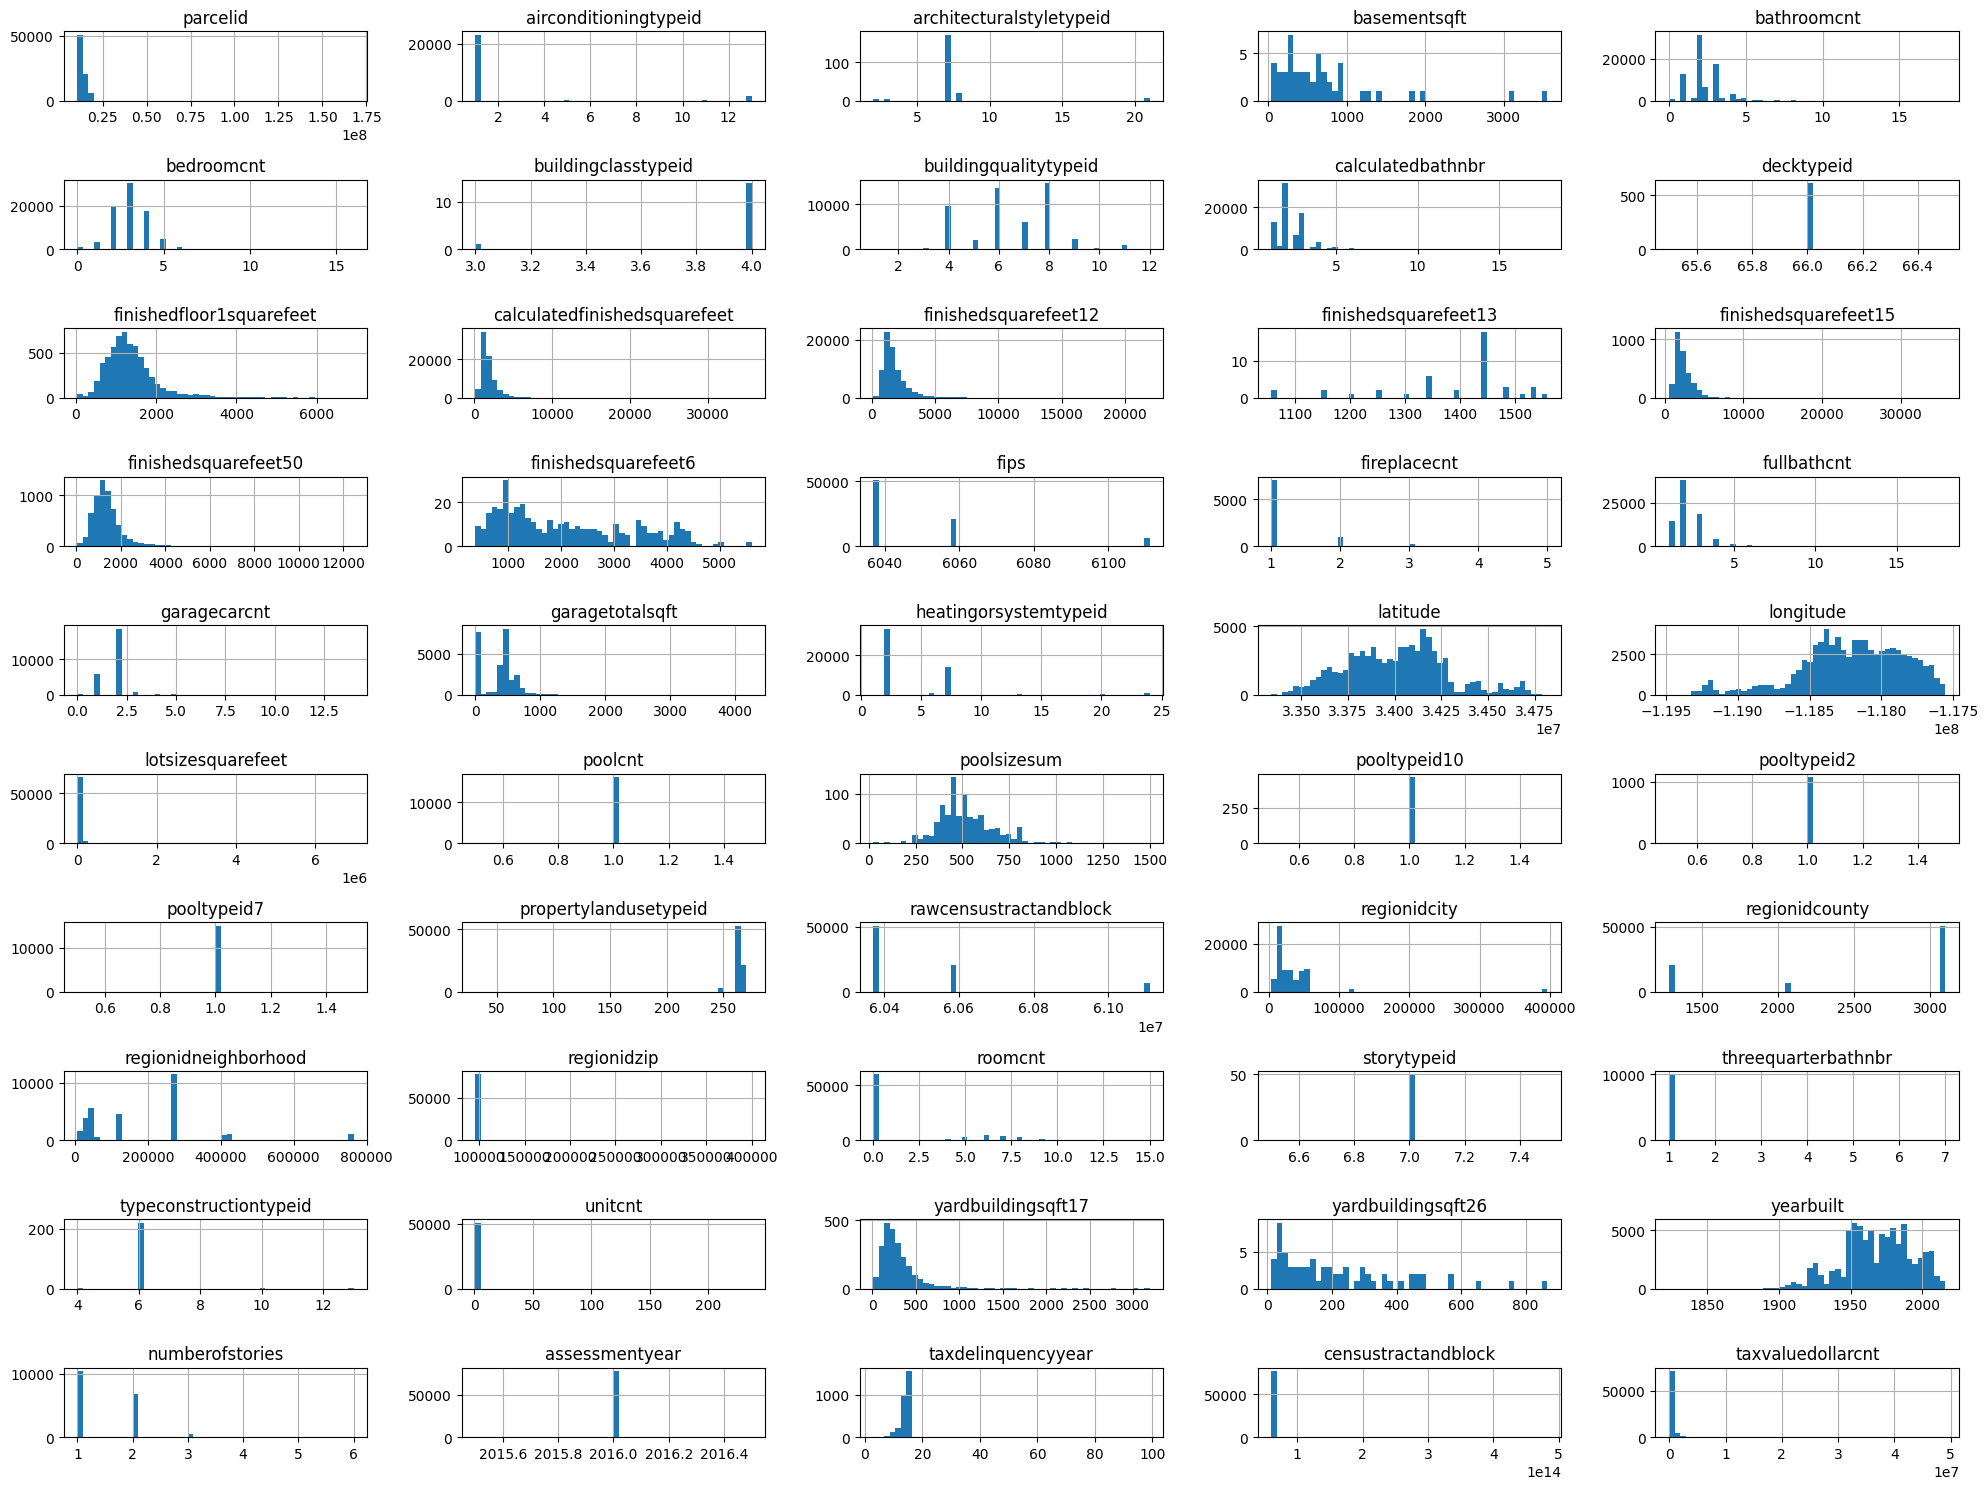

In [4]:
def plot_numeric_histograms(df: pd.DataFrame, bins: int = 50) -> None:
    """
    Plots histograms for all numeric features in the DataFrame.

    Args:
        df (pd.DataFrame): Dataset to plot.
        bins (int): Number of bins to use in each histogram.
    """
    df.hist(figsize=(20, 15), bins=bins, layout=(-1, 5))
    plt.tight_layout()
    plt.show()

# Example usage:
plot_numeric_histograms(df)

### Identifying Low-Cardinality Categorical Features

The `find_low_cardinality_categoricals()` function helps us pinpoint columns that are likely categorical (but maybe stored as object or even numeric types). These are good candidates for encoding.

In [5]:
def find_low_cardinality_categoricals(df: pd.DataFrame, threshold: int = 10, show: bool = True) -> list:
    """
    Identifies and optionally displays low-cardinality categorical features.

    Args:
        df (pd.DataFrame): Dataset to scan.
        threshold (int): Max number of unique values to be considered "low cardinality".
        show (bool): If True, print the feature names.

    Returns:
        list: Column names of low-cardinality categorical features.
    """
    low_cardinality = df.nunique()[df.nunique() < threshold].index.tolist()
    categoricals = [
        col for col in low_cardinality 
        if df[col].dtype == "object" or df[col].dtype.name == "category"
    ]
    if show:
        print("Low-cardinality categorical features:")
        print(categoricals)
    return categoricals

We could possibly remove the following variables simply due to sheer numbers of null presence:
| Field Name                  | Non-Null Count | Total Count | Percentage (%) |
|-----------------------------|----------------|-------------|----------------|
| architecturalstyletypeid    | 207            | 77613       | 0.27           |
| basementsqft                | 50             | 77613       | 0.06           |
| buildingclasstypeid         | 15             | 77613       | 0.02           |
| decktypeid                  | 614            | 77613       | 0.79           |
| finishedfloor1squarefeet    | 6037           | 77613       | 7.78           |
| finishedsquarefeet13        | 42             | 77613       | 0.05           |
| finishedsquarefeet15        | 3027           | 77613       | 3.90           |
| finishedsquarefeet50        | 6037           | 77613       | 7.78           |
| finishedsquarefeet6         | 386            | 77613       | 0.50           |
| poolsizesum                 | 869            | 77613       | 1.12           |
| pooltypeid10                | 465            | 77613       | 0.60           |
| pooltypeid2                 | 1074           | 77613       | 1.38           |
| storytypeid                 | 50             | 77613       | 0.06           |
| typeconstructiontypeid      | 223            | 77613       | 0.29           |
| yardbuildingsqft17          | 2393           | 77613       | 3.08           |
| yardbuildingsqft26          | 70             | 77613       | 0.09           |
| fireplaceflag               | 172            | 77613       | 0.22           |

## Project Framing & Objectives

### 1.1 What’s the business goal?  
We’re building a regression model to predict property values using real estate data — things like square footage, location, and amenities. This supports smarter pricing and valuation tools.

### 1.2 How will it be used?  
Our model can help real estate professionals — especially marketing teams — make more data-driven decisions. Zillow (or similar platforms) could use it in automated valuation tools.

### 1.3 How do we measure success?  
We’ll track RMSE and R² on validation/test data. A strong model should generalize well, handle variation across cities/neighborhoods, and be easy to understand.

### Re-checking the Dataset Structure

We revisit the basic structure, types, and missing values of the dataset. This helps confirm our earlier observations and catches any subtle changes after framing or minor cleaning steps.

In [6]:
# Re-run our EDA summary in case anything has changed
explore_dataframe(df)

First five rows:


,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,...,yardbuildingsqft17,yardbuildingsqft26,yearbuilt,numberofstories,fireplaceflag,assessmentyear,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,taxvaluedollarcnt
0,14297519,NaN,NaN,NaN,3.5,4.0,NaN,NaN,3.5,NaN,...,NaN,NaN,1998.0,NaN,NaN,2016.0,NaN,NaN,6.059063e+13,1023282.0
1,17052889,NaN,NaN,NaN,1.0,2.0,NaN,NaN,1.0,NaN,...,NaN,NaN,1967.0,1.0,NaN,2016.0,NaN,NaN,6.111001e+13,464000.0
2,14186244,NaN,NaN,NaN,2.0,3.0,NaN,NaN,2.0,NaN,...,NaN,NaN,1962.0,1.0,NaN,2016.0,NaN,NaN,6.059022e+13,564778.0
3,12177905,NaN,NaN,NaN,3.0,4.0,NaN,8.0,3.0,NaN,...,NaN,NaN,1970.0,NaN,NaN,2016.0,NaN,NaN,6.037300e+13,145143.0
4,10887214,1.0,NaN,NaN,3.0,3.0,NaN,8.0,3.0,NaN,...,NaN,NaN,1964.0,NaN,NaN,2016.0,NaN,NaN,6.037124e+13,119407.0



DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77613 entries, 0 to 77612
Data columns (total 55 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   parcelid                      77613 non-null  int64  
 1   airconditioningtypeid         25007 non-null  float64
 2   architecturalstyletypeid      207 non-null    float64
 3   basementsqft                  50 non-null     float64
 4   bathroomcnt                   77579 non-null  float64
 5   bedroomcnt                    77579 non-null  float64
 6   buildingclasstypeid           15 non-null     float64
 7   buildingqualitytypeid         49809 non-null  float64
 8   calculatedbathnbr             76963 non-null  float64
 9   decktypeid                    614 non-null    float64
 10  finishedfloor1squarefeet      6037 non-null   float64
 11  calculatedfinishedsquarefeet  77378 non-null  float64
 12  finishedsquarefeet12          73923 non-nul

parcelid                        77414
latitude                        64038
longitude                       62461
taxvaluedollarcnt               50949
rawcensustractandblock          39188
censustractandblock             39006
lotsizesquarefeet               18848
calculatedfinishedsquarefeet     4972
finishedsquarefeet12             4868
propertyzoningdesc               1907
finishedsquarefeet50             1807
finishedfloor1squarefeet         1787
finishedsquarefeet15             1724
garagetotalsqft                   839
yardbuildingsqft17                540
regionidneighborhood              480
regionidzip                       389
finishedsquarefeet6               350
poolsizesum                       262
regionidcity                      175
yearbuilt                         136
propertycountylandusecode          75
yardbuildingsqft26                 59
basementsqft                       43
bathroomcnt                        22
calculatedbathnbr                  21
bedroomcnt  


Missing values (%):


buildingclasstypeid             99.980673
finishedsquarefeet13            99.945885
basementsqft                    99.935578
storytypeid                     99.935578
yardbuildingsqft26              99.909809
fireplaceflag                   99.778388
architecturalstyletypeid        99.733292
typeconstructiontypeid          99.712677
finishedsquarefeet6             99.502661
pooltypeid10                    99.400874
decktypeid                      99.208895
poolsizesum                     98.880342
pooltypeid2                     98.616211
hashottuborspa                  98.017085
yardbuildingsqft17              96.916754
taxdelinquencyyear              96.263513
taxdelinquencyflag              96.263513
finishedsquarefeet15            96.099880
finishedsquarefeet50            92.221664
finishedfloor1squarefeet        92.221664
fireplacecnt                    89.320088
threequarterbathnbr             86.978985
pooltypeid7                     80.571554
poolcnt                         79


Summary statistics for numerical columns:


,count,mean,std,min,25%,50%,75%,max
parcelid,77613.0,1.300781e+07,3.518717e+06,1.071186e+07,1.153821e+07,1.253004e+07,1.421101e+07,1.676893e+08
airconditioningtypeid,25007.0,1.812013e+00,2.965768e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.300000e+01
architecturalstyletypeid,207.0,7.386473e+00,2.728030e+00,2.000000e+00,7.000000e+00,7.000000e+00,7.000000e+00,2.100000e+01
basementsqft,50.0,6.797200e+02,6.897035e+02,3.800000e+01,2.730000e+02,5.150000e+02,7.965000e+02,3.560000e+03
bathroomcnt,77579.0,2.298496e+00,9.967317e-01,0.000000e+00,2.000000e+00,2.000000e+00,3.000000e+00,1.800000e+01
bedroomcnt,77579.0,3.053223e+00,1.140480e+00,0.000000e+00,2.000000e+00,3.000000e+00,4.000000e+00,1.600000e+01
buildingclasstypeid,15.0,3.933333e+00,2.581989e-01,3.000000e+00,4.000000e+00,4.000000e+00,4.000000e+00,4.000000e+00
buildingqualitytypeid,49809.0,6.533779e+00,1.722062e+00,1.000000e+00,6.000000e+00,6.000000e+00,8.000000e+00,1.200000e+01
calculatedbathnbr,76963.0,2.316392e+00,9.796893e-01,1.000000e+00,2.000000e+00,2.000000e+00,3.000000e+00,1.800000e+01
decktypeid,614.0,6.600000e+01,0.000000e+00,6.600000e+01,6.600000e+01,6.600000e+01,6.600000e+01,6.600000e+01


### 2.A.1: Which features are categorical?

Features like `propertylandusetypeid`, `airconditioningtypeid`, and `regionidzip` are technically numeric, but function as categories. They represent types or group identifiers and should be encoded accordingly.

### 2.A.2: Any features that seem useless?

Yes — columns like `decktypeid`, `basementsqft`, and `fireplaceflag` have very few non-null entries and don't seem helpful for our valuation task. Unless we find they’re critical later, we’ll likely drop them.

### 2.A.3: Useless Features by Missingness

Features like `basementsqft`, `yardbuildingsqft17`, and `finishedsquarefeet6` are missing in 99%+ of rows. That’s too sparse for reliable modeling, so we’ll consider dropping them.

### 2.A.4: Useless Features by Uniqueness

`parcelid` is a unique identifier for each row. Since it carries no generalizable pattern, we’ll exclude it from modeling.

### Additional Notes

We also noticed potential redundancy in some features, like square footage and bathroom count variations. These may be dropped or consolidated later during feature selection.

### Starting 2.B, Target + Predictor Distributions

Boxplots help us spot outliers and skew in both the target (`taxvaluedollarcnt`) and predictors. These patterns influence how we scale or transform features later.

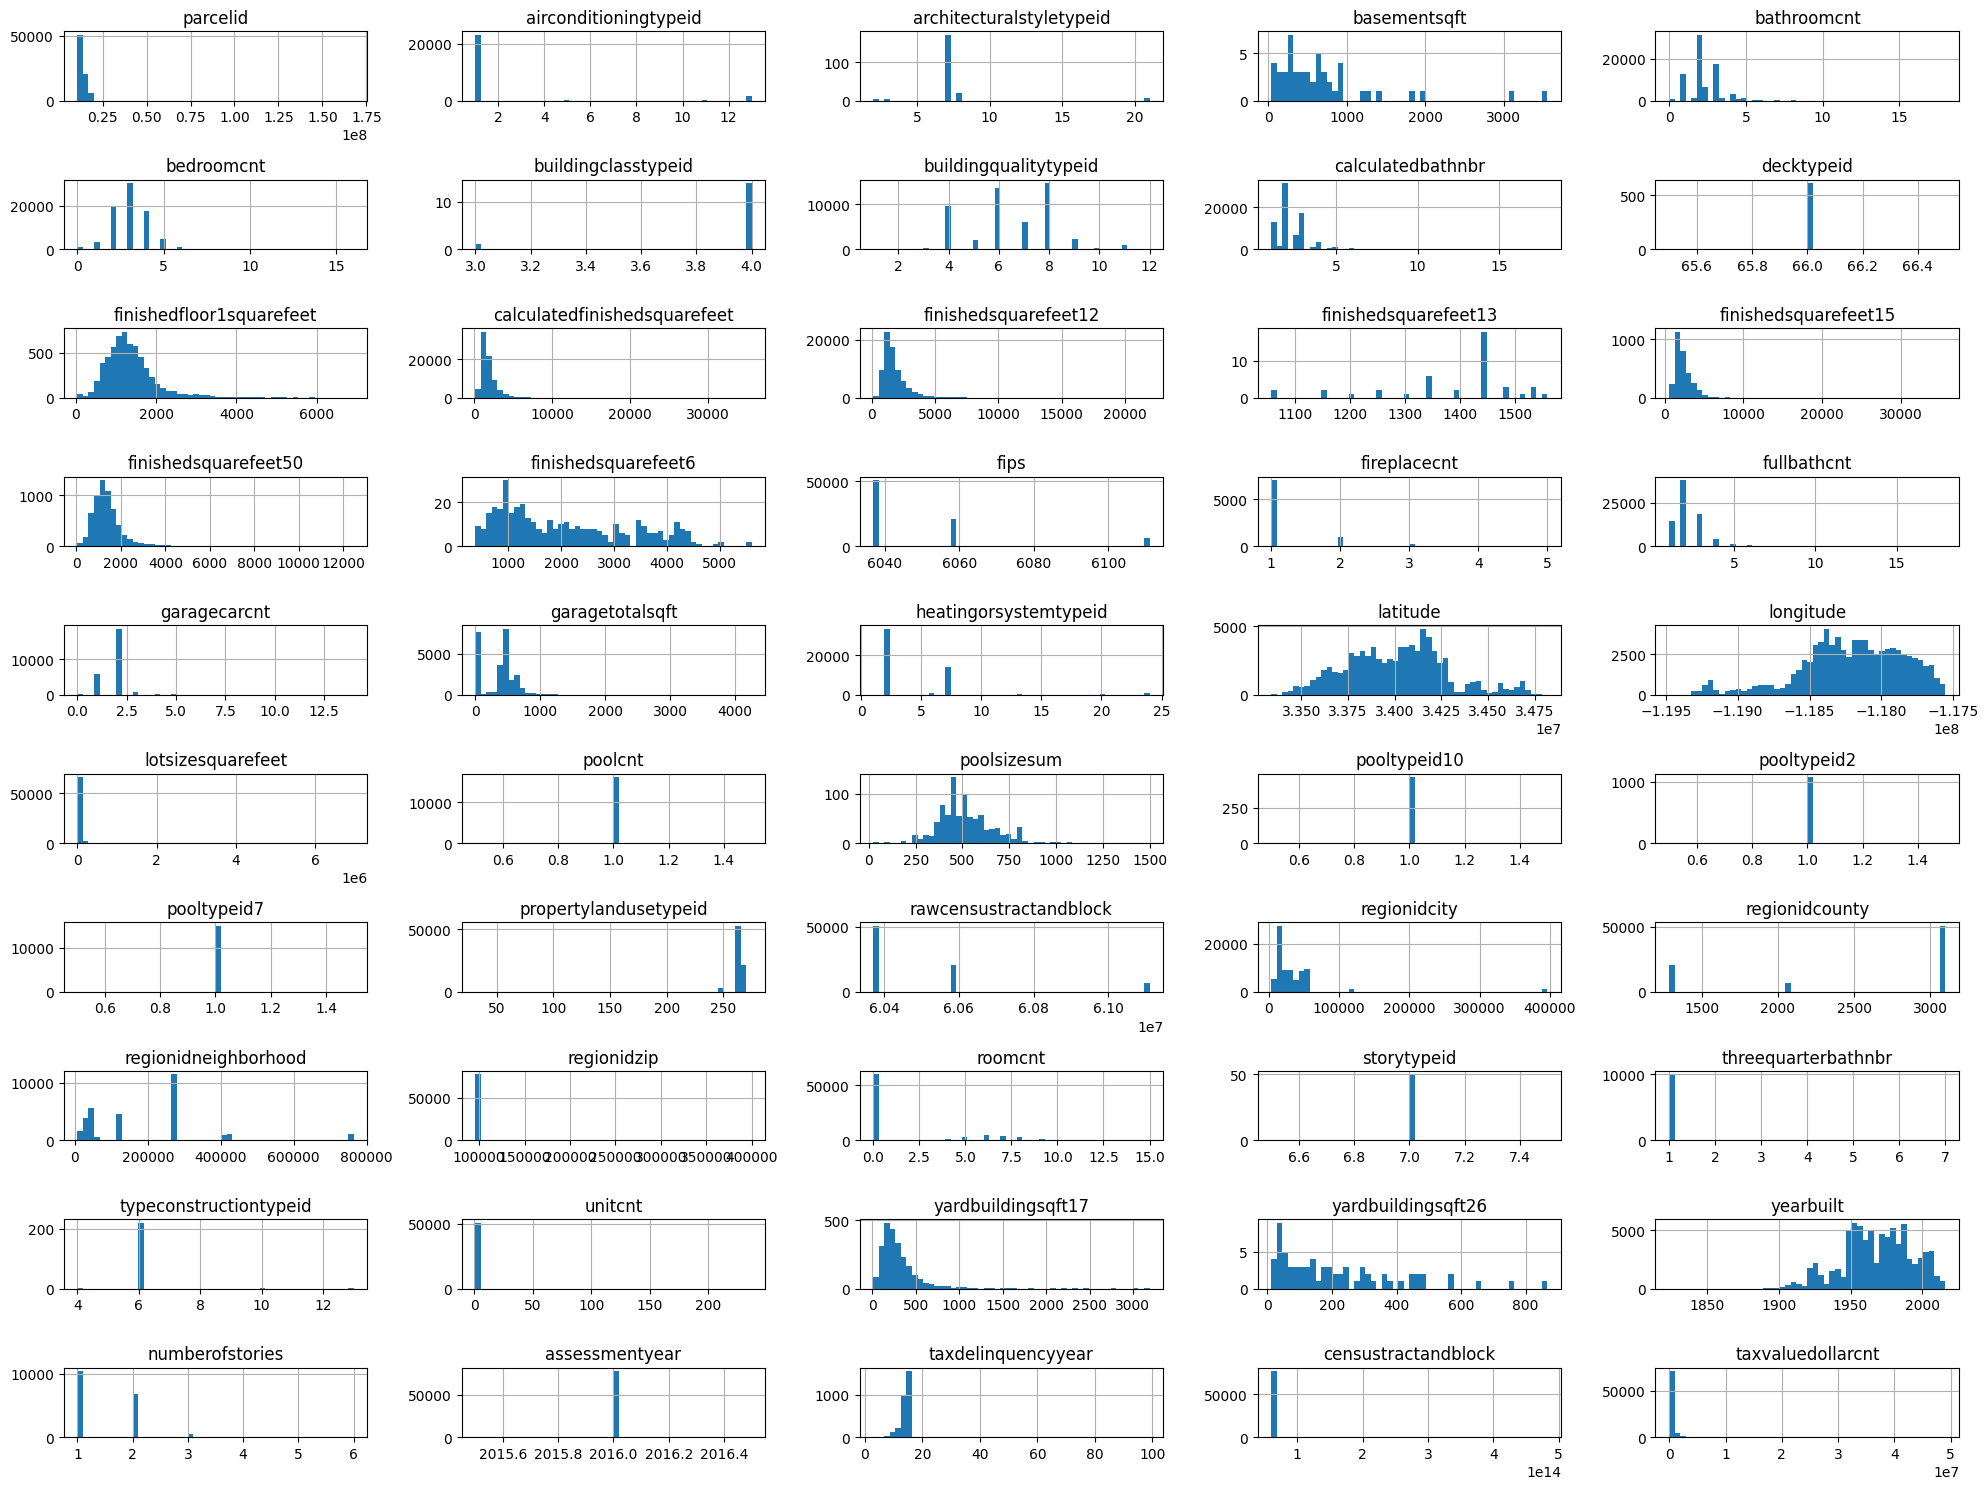

In [7]:
df.hist(figsize=(20, 15), bins=50, layout=(-1, 5))
plt.tight_layout()
plt.show()

In [8]:
def plot_numeric_histograms(df: pd.DataFrame, bins: int = 50) -> None:
    df.hist(figsize=(20, 15), bins=bins, layout=(-1, 5))
    plt.tight_layout()
    plt.show()

### Target + Predictor Distributions

Boxplots help us spot outliers and skew in both the target (`taxvaluedollarcnt`) and predictors. These patterns influence how we scale or transform features later.

In [12]:
def plot_target_distribution_and_predictors(
    df: pd.DataFrame,
    target: str,
    predictors: list,
    box_color: str = "gray",
    hist_color: str = "seagreen",
    kde_line: str = "darkgreen"
) -> None:
    """
    Plots a boxplot for the target variable and histograms with KDEs for key predictors.
    
    Args:
        df (pd.DataFrame): The dataset.
        target (str): Name of the target column.
        predictors (list): List of predictor columns to show as histograms.
        box_color (str): Color for target boxplot.
        hist_color (str): Color for histogram fill.
        kde_line (str): Color for KDE line.
    """
    total = len(predictors) + 1
    rows = (total + 1) // 2
    fig, axes = plt.subplots(rows, 2, figsize=(14, rows * 4))
    axes = axes.flatten()

    # Plot target as boxplot
    sns.boxplot(x=df[target], ax=axes[0], color=box_color)
    axes[0].set_title(f"Boxplot of {target}", fontsize=12)

    # Predictors as histograms + KDE
    for i, col in enumerate(predictors):
        sns.histplot(
            df[col], 
            kde=True, 
            ax=axes[i + 1], 
            color=hist_color
        )
        axes[i + 1].set_title(f"Distribution of {col}", fontsize=12)

    plt.tight_layout()
    plt.show()

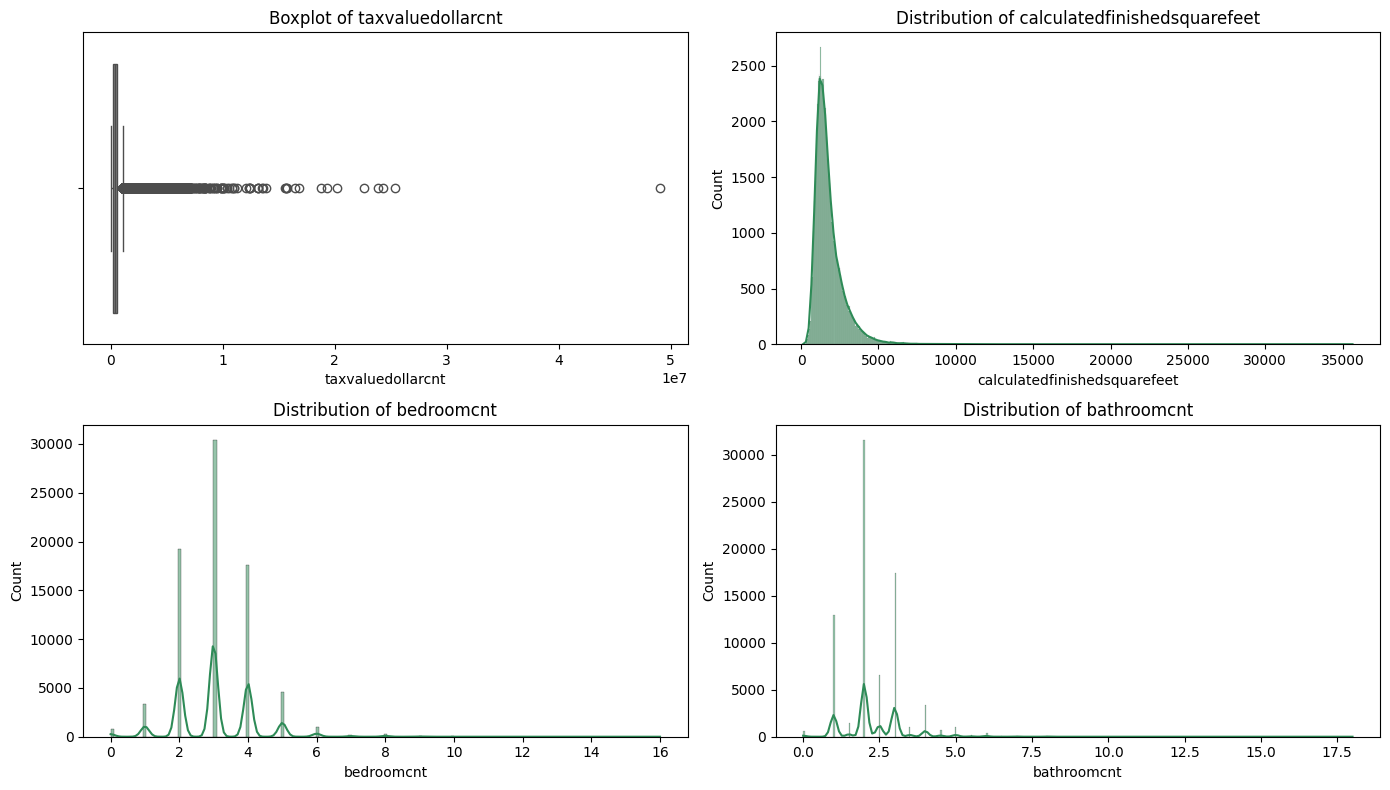

In [13]:
plot_target_distribution_and_predictors(
    df=df, 
    target="taxvaluedollarcnt", 
    predictors=["calculatedfinishedsquarefeet", "bedroomcnt", "bathroomcnt"]
)

### 2.B Summary: Feature Distribution Observations

- The target `taxvaluedollarcnt` is highly skewed (right-tailed), which suggests high-value outliers may affect regression.
- `calculatedfinishedsquarefeet`, `bathroomcnt`, and `bedroomcnt` all show decent spread but possible skew or multiple modes.
- We'll consider transformation or filtering based on these insights.

## Part 3: Clean the Data (Drop, Impute, Encode)

From here on, we begin modifying the data for modeling. At each stage, we’ll use new variable names like `df_dropped`, `df_imputed`, and so on, to preserve version history and track changes step-by-step.

### Correlation Analysis

Here we check for redundancy among feature groups using correlation matrices and visualizations. Highly correlated features (e.g., square footage, bathroom types) will be simplified by keeping the most complete column.

In [ ]:
# === Reusable Function: Group Feature Correlation with Heatmap ===
def check_feature_group_correlation(df: pd.DataFrame, features: list, group_name: str, show: bool = True) -> pd.DataFrame:
    """
    Displays a correlation matrix and heatmap for a group of features.

    Args:
        df (pd.DataFrame): The dataset.
        features (list): Features to compare.
        group_name (str): Group label for plot titles.
        show (bool): Show heatmap and plots.

    Returns:
        pd.DataFrame: Correlation matrix of selected features.
    """
    subset = df[features].dropna(how='all')
    corr = subset.corr()

    if show:
        print(f"\nCorrelation matrix for {group_name}:")
        display(corr)

        plt.figure(figsize=(10, 8))
        sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt='.4f')
        plt.title(f'Correlation Matrix: {group_name}')
        plt.tight_layout()
        plt.show()

        if len(features) == 2:
            plt.figure(figsize=(8, 6))
            sns.scatterplot(data=subset, x=features[0], y=features[1], alpha=0.5)
            plt.title(f'Scatter Plot: {features[0]} vs {features[1]}')
            plt.tight_layout()
            plt.show()

    return corr

In [ ]:
# 1. Square Footage
sqft_features = ['calculatedfinishedsquarefeet', 'finishedsquarefeet12', 'finishedsquarefeet13', 'finishedsquarefeet15', 'finishedsquarefeet50', 'finishedsquarefeet6']
sqft_corr = check_feature_group_correlation(df, sqft_features, 'Square Footage')

# 2. Bathroom Counts
bath_features = ['bathroomcnt', 'calculatedbathnbr', 'fullbathcnt', 'threequarterbathnbr']
bath_corr = check_feature_group_correlation(df, bath_features, 'Bathroom Features')

# 3. Census Features
census_features = ['rawcensustractandblock', 'censustractandblock']
census_corr = check_feature_group_correlation(df, census_features, 'Census Features')

# 4. Pool Features
pool_features = ['poolcnt', 'pooltypeid7']
pool_corr = check_feature_group_correlation(df, pool_features, 'Pool Features')

# Extra Checks on Pool Data
print(f"\nPercentage of properties with missing pool count: {df['poolcnt'].isnull().mean() * 100:.2f}%")
both_pool = (~df['poolcnt'].isnull()) & (~df['pooltypeid7'].isnull())
print(f"Properties with both pool features non-null: {both_pool.sum()}")
print(f"Non-null poolcnt: {(~df['poolcnt'].isnull()).sum()}")
print(f"Non-null pooltypeid7: {(~df['pooltypeid7'].isnull()).sum()}")

### Deep-Dive Pairwise Feature Comparisons

To avoid dropping features that might be similar but not redundant, we use this detailed comparison. It checks:
- Correlation coefficient
- Whether they’re scaled versions of each other
- Outlier examples

In [ ]:
# === Reusable Function: Deep Pairwise Correlation Analysis ===
def analyze_pairwise_correlation(df: pd.DataFrame, feature1: str, feature2: str, show: bool = True) -> float:
    """
    Compares two features: correlation, scale similarity, and outlier differences.

    Returns Pearson correlation and displays plots + diagnostics.
    """
    # [PASTE full function code here... unchanged]

In [ ]:
# === Detailed Pairwise Correlation Analysis ===
analyze_pairwise_correlation(df, 'calculatedfinishedsquarefeet', 'finishedsquarefeet12')
analyze_pairwise_correlation(df, 'calculatedfinishedsquarefeet', 'finishedsquarefeet13')
analyze_pairwise_correlation(df, 'calculatedfinishedsquarefeet', 'finishedsquarefeet15')
analyze_pairwise_correlation(df, 'calculatedfinishedsquarefeet', 'finishedsquarefeet6')
analyze_pairwise_correlation(df, 'calculatedbathnbr', 'bathroomcnt')

### Feature Dropping Based on Redundancy

Based on correlation and completeness, we dropped features that are:
- Functionally identical to others (`bathroomcnt`, `finishedsquarefeet12`)
- Redundant geographic fields
- Unique IDs or constants

We keep the most complete and interpretable columns to reduce noise.

In [ ]:
def drop_irrelevant_features(df: pd.DataFrame, columns_to_drop: list, show: bool = True) -> pd.DataFrame:
    """
    Drops specified non-predictive or redundant features from the dataset.

    Args:
        df (pd.DataFrame): Input dataframe.
        columns_to_drop (list): List of column names to remove.
        show (bool): If True, prints list and new shape.

    Returns:
        pd.DataFrame: Cleaned DataFrame.
    """
    df_reduced = df.drop(columns=columns_to_drop).copy()
    if show:
        print("Dropped irrelevant features:", columns_to_drop)
        print("New shape:", df_reduced.shape)
    return df_reduced

In [ ]:
# === Drop irrelevant or redundant features after correlation analysis ===
drop_irrelevant = [
    "parcelid",                # Unique ID – not predictive
    "rawcensustractandblock",  # High-cardinality
    "censustractandblock",     # Redundant with above
    "regionidzip",             # Geographic ID
    "assessmentyear",          # Constant
    "finishedsquarefeet12",    # Duplicate of calculatedfinishedsquarefeet
    "finishedsquarefeet13",    # ""
    "finishedsquarefeet15",    # ""
    "finishedsquarefeet6",     # ""
    "bathroomcnt"              # Duplicate of calculatedbathnbr
]

df_cleaned = drop_irrelevant_features(df, drop_irrelevant)

### 3.A: Justifying Feature Drops

We dropped features that either:
- Had no predictive value (`parcelid`)
- Were constant (`assessmentyear`)
- Were highly correlated and less complete (`bathroomcnt`, `finishedsquarefeet12`, etc.)

Specifically:
- `calculatedfinishedsquarefeet` was kept over similar features due to higher completeness (99.7% vs 95.2%)
- `calculatedbathnbr` was kept for similar reasons

### Reflection on Dropping Redundant Features

Dropping redundant or duplicated features was critical to simplify the dataset and avoid multicollinearity.  
By keeping only the most complete and interpretable columns (e.g., `calculatedfinishedsquarefeet` instead of multiple similar sqft measures), we ensure the model focuses on clean, non-redundant signals.

### 3.B: Drop Features with Excessive Missingness

Now we identify features with high missing values that also lack strong correlation to the target. These are unlikely to help the model and may introduce noise.

### Identifying Weak Features: High Nulls + Low Correlation

This function highlights features that are both:
- Highly incomplete (over 90% missing)
- Weakly correlated to the target (abs(corr) < 0.1)

These features likely won't help the model and may just add noise, so we’ll consider dropping them next.

In [ ]:
def identify_high_null_low_corr_features(df: pd.DataFrame, target: str, null_thresh: float = 0.90, corr_thresh: float = 0.1, show: bool = True) -> pd.DataFrame:
    """
    Identifies features with high null rates and low correlation with the target.

    Args:
        df (pd.DataFrame): The input dataset.
        target (str): The target column to check correlation against.
        null_thresh (float): Proportion of missing values allowed (e.g., 0.90).
        corr_thresh (float): Absolute correlation threshold below which features are flagged.
        show (bool): If True, displays summary DataFrame.

    Returns:
        pd.DataFrame: A summary of high-null, low-corr columns.
    """
    high_null_cols = df.columns[df.isnull().mean() > null_thresh]
    correlations = df.corr(numeric_only=True)[target]
    low_corr_cols = correlations[correlations.abs() < corr_thresh].index
    drop_candidates = list(set(high_null_cols) & set(low_corr_cols))

    summary_data = []
    for col in drop_candidates:
        preview = df[col].dropna().unique()[:3]
        summary_data.append({
            "Feature": col,
            "Data Preview": preview,
            "Correlation": correlations.get(col),
            "Null Count": df[col].isnull().sum(),
            "Non-Null Count": df[col].notnull().sum()
        })

    drop_summary_df = pd.DataFrame(summary_data).sort_values(
        by="Correlation", key=lambda x: x.abs(), ascending=True
    ).reset_index(drop=True)

    if show:
        print(f"\nHigh-null, low-correlation candidates (null > {null_thresh*100:.0f}%, corr < {corr_thresh}):")
        display(drop_summary_df)

    return drop_summary_df

In [ ]:
# Step 3.B – Use function to identify weak features
drop_summary_df = identify_high_null_low_corr_features(df_cleaned, target="taxvaluedollarcnt")

### Dropping Weak Features

Now that we’ve identified columns with both high missingness and little correlation to the target,
we drop them from the dataset. This helps reduce noise and dimensionality before encoding or modeling.

In [ ]:
def drop_high_null_low_corr(
    df: pd.DataFrame, 
    target: str, 
    null_thresh: float = 0.90, 
    corr_thresh: float = 0.10, 
    show: bool = True
) -> tuple[pd.DataFrame, list]:
    """
    Drops features that have a high proportion of missing values AND are weakly correlated with the target.

    Args:
        df (pd.DataFrame): Dataset to process.
        target (str): Name of the target column.
        null_thresh (float): Null value threshold (default: 90%).
        corr_thresh (float): Correlation threshold (default: 0.10).
        show (bool): If True, print dropped features and reason.

    Returns:
        tuple: (cleaned DataFrame, list of dropped column names)
    """
    high_null = df.columns[df.isnull().mean() > null_thresh]
    numeric_df = df.select_dtypes(include='number')
    correlations = numeric_df.corr()[target].fillna(0)
    low_corr = correlations[correlations.abs() < corr_thresh].index

    to_drop = list(set(high_null) & set(low_corr))

    if show:
        print(f"\nDropping {len(to_drop)} features with >{null_thresh*100:.0f}% missing and low correlation:")
        for col in to_drop:
            print(f" - {col}: {df[col].isnull().mean()*100:.1f}% null, corr = {correlations[col]:.3f}")

    df_cleaned = df.drop(columns=to_drop).copy()
    return df_cleaned, to_drop

In [ ]:
# Step 3.B – Drop the features we identified
df_null_cleaned, dropped_features = drop_high_null_low_corr(df_cleaned, target="taxvaluedollarcnt")

### Applying High-Null + Low-Correlation Drop

We now run our drop function on `df_cleaned` to remove features that were:
- More than 60–90% missing
- Weakly correlated with the target (|corr| < 0.3)

This produces a new version of the dataset: `df_null_cleaned`, which is smaller and cleaner moving into the next steps.

In [ ]:
def plot_target_correlations(df, target='taxvaluedollarcnt', top_n=10, method='pearson', figsize=(12, 10)):
    """
    Plot correlations between the target variable and its most correlated numeric features.

    Parameters:
    -----------
    df : pandas DataFrame
        The input DataFrame (should be cleaned beforehand)
    target : str, default='taxvaluedollarcnt'
        The target variable to correlate against
    top_n : int, default=10
        Number of top features to include (excluding the target itself)
    method : str, default='pearson'
        Correlation method: 'pearson', 'kendall', or 'spearman'
    figsize : tuple
        Size of the output figure
    """
    # Select numeric features
    numeric_df = df.select_dtypes(include=[np.number])
    
    # Compute correlation with the target
    target_corr = numeric_df.corrwith(df[target], method=method).sort_values(ascending=False)
    
    # Drop the target itself and select top N correlated features
    top_features = target_corr.drop(index=target).head(top_n).index.tolist()
    
    # Build subset DataFrame with target + top features
    subset_cols = [target] + top_features
    corr_subset = numeric_df[subset_cols].corr(method=method)
    
    # Plot heatmap
    plt.figure(figsize=figsize)
    sns.heatmap(
        corr_subset,
        annot=True,
        fmt=".2f",
        cmap='coolwarm',
        vmax=1.0,
        vmin=-1.0,
        center=0,
        square=True,
        linewidths=0.5
    )
    plt.title(f"Top {top_n} {method.capitalize()} Correlated Features with '{target}'", fontsize=16)
    plt.tight_layout()
    plt.show()
    
    return top_features

# ---- Usage with your own DataFrame ----
top_features = plot_target_correlations(df_cleaned, top_n=10, method='pearson')

In [ ]:
# Step 3.B – Apply feature drop for high-null + low-correlation fields
df_null_cleaned, dropped_features = drop_high_null_low_corr(df_cleaned, target="taxvaluedollarcnt")

### Reflection on 60% Missing Threshold

We chose a 60% missingness threshold because features with extreme sparsity would be unreliable predictors and could introduce noise.  
By filtering out features missing in the majority of properties, we maintain a more stable and generalizable dataset for modeling.

### Null Value Summary

This function gives a quick overview of how much missing data remains in the current dataset.  
Here, we filter to only show columns with more than 1% missing values, helping us decide whether to impute or drop in the next step.

In [ ]:
def summarize_nulls(df: pd.DataFrame, sort_by: str = 'percent', threshold: float = 0.0, show: bool = True) -> pd.DataFrame:
    """
    Summarizes null values in the dataset.

    Args:
        df (pd.DataFrame): Dataset to analyze.
        sort_by (str): 'percent' or 'count' — column to sort by.
        threshold (float): Minimum % of nulls to include in output.
        show (bool): If True, displays the summary.

    Returns:
        pd.DataFrame: Table showing columns with null counts and percentages.
    """
    null_counts = df.isnull().sum()
    null_percents = null_counts / len(df) * 100

    summary_df = pd.DataFrame({
        'Column': null_counts.index,
        'Null Count': null_counts.values,
        'Null Percent': null_percents.round(2),
        'Data Type': df.dtypes.astype(str).values
    })

    filtered_df = summary_df[summary_df['Null Percent'] > threshold * 100]

    sort_column = 'Null Count' if sort_by == 'count' else 'Null Percent'
    result = filtered_df.sort_values(by=sort_column, ascending=False).reset_index(drop=True)

    if show:
        display(result)

    return result

In [ ]:
# Check remaining nulls after drop step
summarize_nulls(df_null_cleaned, threshold=0.01)

### Top Correlated Features

This heatmap shows which features are most linearly related to our target (`taxvaluedollarcnt`).
We'll use this as a guide when choosing features for modeling — strong correlations are good indicators for prediction potential.

In [ ]:
def plot_target_correlations(
    df: pd.DataFrame,
    target: str = 'taxvaluedollarcnt',
    top_n: int = 10,
    method: str = 'pearson',
    figsize: tuple = (12, 10),
    show: bool = True
) -> list:
    """
    Plots a heatmap of the top N features most correlated with the target variable.

    Args:
        df (pd.DataFrame): Input dataset.
        target (str): Target column name.
        top_n (int): Number of top correlated features to show.
        method (str): Correlation method ('pearson', 'spearman', etc.).
        figsize (tuple): Size of the heatmap figure.
        show (bool): If True, displays the heatmap.

    Returns:
        list: Top N feature names most correlated with the target.
    """
    numeric_df = df.select_dtypes(include=[np.number])
    target_corr = numeric_df.corrwith(df[target], method=method).sort_values(ascending=False)

    # Drop the target itself from results
    top_features = target_corr.drop(index=target).head(top_n).index.tolist()
    corr_subset = numeric_df[[target] + top_features].corr(method=method)

    if show:
        plt.figure(figsize=figsize)
        sns.heatmap(
            corr_subset, annot=True, fmt=".2f", cmap='coolwarm',
            vmax=1.0, vmin=-1.0, center=0, square=True, linewidths=0.5
        )
        plt.title(f"Top {top_n} {method.capitalize()} Correlated Features with '{target}'")
        plt.tight_layout()
        plt.show()

    return top_features

In [ ]:
# Plot top 10 most correlated features
top_features = plot_target_correlations(df_null_cleaned, top_n=10)

### Why We Added Feature Variance Testing

Testing for feature variance helps identify columns that are nearly constant — meaning they offer little to no value to the model. These features may still have numeric values, but their lack of diversity makes them poor predictors.

### Removing Low-Variance Features

We use `VarianceThreshold` to filter out numeric features with almost no variance. These are unlikely to help in modeling and can contribute noise or overfitting.

In [ ]:
from sklearn.feature_selection import VarianceThreshold

def remove_low_variance_features(df: pd.DataFrame, threshold: float = 0.0, show: bool = True) -> tuple[pd.DataFrame, list]:
    """
    Removes features with variance below the specified threshold.

    Args:
        df (pd.DataFrame): Dataset to evaluate (numeric columns only).
        threshold (float): Variance threshold.
        show (bool): If True, prints removed columns.

    Returns:
        Tuple: (Cleaned DataFrame, List of dropped column names)
    """
    numeric_df = df.select_dtypes(include='number')
    selector = VarianceThreshold(threshold)
    selector.fit(numeric_df)

    retained = numeric_df.columns[selector.get_support()]
    dropped = list(set(numeric_df.columns) - set(retained))

    df_reduced = df.drop(columns=dropped)

    if show:
        print(f"Dropped {len(dropped)} low-variance features:")
        for col in dropped:
            print(f" - {col}")

    return df_reduced, dropped

In [ ]:
# Step 3.B continued — remove low-variance columns from the cleaned dataset
df_var_filtered, low_var_cols = remove_low_variance_features(df_null_cleaned, threshold=0.0)

### Full Correlation Heatmap

This heatmap provides a bird’s-eye view of correlations across all numeric features. It’s useful for spotting redundant predictors or multicollinearity risks before modeling.

In [ ]:
def plot_full_correlation_matrix(df: pd.DataFrame, method: str = 'pearson', figsize: tuple = (12, 10), show: bool = True):
    """
    Plots a full correlation heatmap for all numeric features.

    Args:
        df (pd.DataFrame): Dataset to plot.
        method (str): Correlation method ('pearson', 'spearman', etc.).
        figsize (tuple): Figure size.
        show (bool): If True, shows the heatmap.
    """
    corr = df.select_dtypes(include='number').corr(method=method)

    if show:
        plt.figure(figsize=figsize)
        sns.heatmap(corr, annot=False, cmap='coolwarm', square=True, linewidths=0.5)
        plt.title(f'Full Correlation Matrix ({method.capitalize()})')
        plt.tight_layout()
        plt.show()

In [ ]:
# Plot full correlation matrix after feature selection
plot_full_correlation_matrix(df_var_filtered)

### 3.B Discussion: Feature Dropping Rationale

We dropped features with more than 60% missing data and correlation below 0.3 with the target.  
This included features like `architecturalstyletypeid`, which add little predictive value due to sparsity.  
The goal was to reduce noise and simplify the dataset without sacrificing useful information.

### Part 3.C: Drop Problematic Samples

We now evaluate row-level issues like:
- Missing target values
- Excessive missing features in a row
- Outliers in key columns (especially the target)

These samples may introduce unreliable patterns or skew our model training.

### Converting Features to Categorical Types

Some numeric columns (like ZIP code or property type) are actually categorical.  
We explicitly convert them to save memory and help future encoding.  
Examples include `regionidzip`, `propertylandusetypeid`, and `unitcnt`.

In [ ]:
def convert_and_report_categoricals(df, verbose=True):
    """
    Converts known numeric columns to categorical based on domain logic.
    Also reports memory savings and dtype changes.
    """
    df_copy = df.copy()
    converted_cols = []

    memory_before = df_copy.memory_usage(deep=True).sum() / 1024**2

    categorical_candidates = [
        'fips', 'buildingqualitytypeid', 'heatingorsystemtypeid',
        'propertylandusetypeid', 'regionidcity', 'regionidcounty',
        'regionidzip', 'unitcnt', 'yearbuilt'
    ]

    for col in categorical_candidates:
        if col in df.columns and pd.api.types.is_numeric_dtype(df[col]):
            n_unique = df[col].nunique()
            null_count = df[col].isnull().sum()

            if n_unique <= 255:
                df_copy[col] = df[col].astype('category')
                conversion_type = 'category'
            elif col == 'yearbuilt':
                df_copy[col] = df[col].astype('Int64')
                conversion_type = 'Int64'
            else:
                continue

            converted_cols.append({
                'column': col,
                'unique_values': n_unique,
                'null_values': null_count,
                'conversion_type': conversion_type
            })

    memory_after = df_copy.memory_usage(deep=True).sum() / 1024**2
    conversion_info = {
        'total_conversions': len(converted_cols),
        'converted_columns': converted_cols,
        'memory_before_MB': round(memory_before, 2),
        'memory_after_MB': round(memory_after, 2)
    }

    if verbose:
        print(f"\nConverted {len(converted_cols)} columns:")
        for info in converted_cols:
            print(f"  - {info['column']}: {info['conversion_type']} ({info['unique_values']} unique, {info['null_values']} nulls)")
        print(f"\nMemory reduced from {memory_before:.2f} MB to {memory_after:.2f} MB")

    return df_copy, conversion_info

In [ ]:
# Convert domain-informed features to categoricals
df_cleaned, conversion_info = convert_and_report_categoricals(df_cleaned)

### Dropping Target Outliers

We use the IQR method to remove extreme values from the `taxvaluedollarcnt` column.  
This helps reduce skew and make the model more robust to outliers.

In [ ]:
def drop_iqr_outliers(df, target="taxvaluedollarcnt", iqr_multiplier=1.5, verbose=True):
    """
    Drops rows where the target variable is an outlier based on IQR.

    Args:
        df (pd.DataFrame): Input dataset.
        target (str): Target column to filter on.
        iqr_multiplier (float): Controls strictness of bounds.
        verbose (bool): If True, prints summary stats.

    Returns:
        pd.DataFrame: Filtered DataFrame without target outliers.
    """
    Q1 = df[target].quantile(0.25)
    Q3 = df[target].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - iqr_multiplier * IQR
    upper = Q3 + iqr_multiplier * IQR

    df_filtered = df[(df[target] >= lower) & (df[target] <= upper)]

    if verbose:
        print(f"Original shape: {df.shape}")
        print(f"Filtered shape: {df_filtered.shape}")
        print(f"Outliers removed: {df.shape[0] - df_filtered.shape[0]}")
        print(f"IQR bounds: {lower:.2f} to {upper:.2f}")

    return df_filtered

In [ ]:
# Remove outliers from the target column using IQR
df_samples = drop_iqr_outliers(df_cleaned, target="taxvaluedollarcnt")

### 3.C Discussion: Sample Dropping

We removed rows that:
- Had more than 60% missing values
- Contained missing target values
- Had extreme target outliers based on IQR

This prevents unreliable or overly influential samples from skewing the model.

### Conservative Imputation

Only features with a logical, low-risk imputation path were filled — such as:
- `lotsizesquarefeet` → filled with median
- `propertycountylandusecode` → filled with mode

We avoid imputing binary flags or high-missing columns to prevent introducing artificial bias.

In [ ]:
def conservative_impute(df: pd.DataFrame, strategy_map: dict = None, verbose: bool = True) -> pd.DataFrame:
    """
    Imputes missing values conservatively using predefined strategies for each feature.

    Args:
        df (pd.DataFrame): The input DataFrame.
        strategy_map (dict): Optional manual overrides of imputation strategy per column.
        verbose (bool): If True, prints imputed columns and strategies.

    Returns:
        pd.DataFrame: DataFrame with selected features imputed.
    """
    df_filled = df.copy()
    imputed = {}

    # Default strategies if not provided
    default_strategy = {
        'median': ['lotsizesquarefeet', 'landtaxvaluedollarcnt'],
        'mode': ['propertycountylandusecode', 'regionidcounty']
    }

    if strategy_map:
        for k in strategy_map:
            default_strategy[k] = strategy_map[k]

    for method, cols in default_strategy.items():
        for col in cols:
            if col in df_filled.columns and df_filled[col].isnull().any():
                if method == 'median':
                    fill_value = df_filled[col].median()
                elif method == 'mode':
                    fill_value = df_filled[col].mode()[0]
                else:
                    continue

                df_filled[col] = df_filled[col].fillna(fill_value)
                imputed[col] = method

    if verbose:
        print("Imputed columns:")
        for col, method in imputed.items():
            print(f"  - {col} ({method})")

    return df_filled

In [ ]:
# Step 3.D – Apply conservative imputation logic
df_imputed = conservative_impute(df_samples)

#### **3.D Discussion:**  
We were highly selective about which missing values to fill. Imputation was only applied where it was safe, such as using median for continuous variables and mode for stable categorical labels.

There were very few imputations that felt safe to make without introducing bias.  
The sensitive binary-like flags (`fireplaceflag`, `hashottuborspa`, `taxdelinquencyflag`) were left untouched because they are sparse and potentially meaningful in their null state.

### Features with High Missing Values and Reasons for Not Imputing

| **Feature**                  | **Definition**                                                                 | **% Missing** | **Reason for Not Imputing**                                                                                                                                                                                                                 |
|------------------------------|--------------------------------------------------------------------------------|--------------|----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| `buildingclasstypeid`        | Classification of the building (e.g., wood frame, masonry).                     | High         | Imputing could misrepresent the structural integrity and classification of the property, leading to inaccurate assessments.                                                                                                                  |
| `finishedsquarefeet6`        | Base unfinished and finished area (e.g., basement and garage).                  | High         | Imputation could lead to incorrect assumptions about the property's usable space, affecting valuation and analysis.                                                                                                                         |
| `storytypeid`                | Type of stories in the building (e.g., basement, attic).                        | High         | Imputing this feature could misrepresent the architectural style and functionality of the property, leading to inaccurate assessments.                                                                                                       |
| `basementsqft`               | Basement square footage.                                                        | High         | Not all properties have basements; imputing could falsely suggest the presence or absence of a basement, leading to incorrect valuations.                                                                                                   |
| `finishedsquarefeet15`       | Total finished living area including additions.                                 | High         | Imputation could lead to incorrect assumptions about the property's size and value, as additions vary widely between properties.                                                                                                            |
| `fireplaceflag`              | Flag indicating the presence of a fireplace.                                    | High         | Imputing could lead to incorrect assumptions about the property's features, as the presence of a fireplace can significantly impact a property's appeal and value.                                                                           |
| `pooltypeid10`               | Indicates the presence of a spa or hot tub.                                     | High         | Imputing could lead to incorrect assumptions about luxury amenities, which significantly impact property valuation and buyer interest.                                                                                                      |
| `decktypeid`                 | Type of deck present on the property.                                           | High         | Imputation could misrepresent the property's outdoor features, leading to inaccurate assessments of its amenities and value.                                                                                                                |
| `pooltypeid2`                | Indicates the presence of a pool with a spa.                                    | High         | Similar to `pooltypeid10`, imputing could lead to incorrect assumptions about luxury amenities, affecting property valuation.                                                                                                               |
| `hashottuborspa`             | Indicates if the property has a hot tub or spa.                                 | High         | Imputing could lead to false assumptions about the presence of luxury amenities, which can significantly influence property valuation and buyer interest.                                                                                   |
| `poolsizesum`                | Total square footage of all pools on the property.                              | High         | Imputation could lead to inaccurate representations of the property's features, as pool size varies widely and significantly affects property value.                                                                                        |
| `taxdelinquencyflag`         | Flag indicating if the property has any tax delinquencies.                      | High         | Imputing could misrepresent the financial status of the property, leading to inaccurate risk assessments.                                                                                                                                   |
| `yardbuildingsqft17`         | Square footage of sheds (non-living areas).                                     | High         | Not all properties have sheds; imputing could falsely suggest the presence or absence of such structures, affecting property assessments.                                                                                                   |
| `threequarterbathnbr`        | Number of 3/4 bathrooms in the property.                                        | High         | Imputation could lead to inaccurate representations of the property's amenities, as the number of bathrooms is a critical factor in property valuation.                                                                                     |
| `finishedsquarefeet50`       | Finished square feet of the first floor.                                        | High         | Imputing could lead to incorrect assumptions about the property's layout and size, affecting valuation and analysis.                                                                                                                        |
| `finishedfloor1squarefeet`   | Finished square feet of the first floor.                                        | High         | Similar to `finishedsquarefeet50`, imputation could misrepresent the property's layout and size, leading to inaccurate assessments.                                                                                                         |
| `fireplacecnt`               | Number of fireplaces in the property.                                           | High         | Imputing could lead to false assumptions about the property's features, as the number of fireplaces can significantly impact a property's appeal and value.                                                                                 |
| `numberofstories`            | Number of stories in the building.                                              | High         | Imputation could misrepresent the property's structure, leading to inaccurate assessments of its size and value.                                                                                                                            |
| `garagetotalsqft`            | Total square footage of the garage.                                             | High         | Not all properties have garages; imputing could falsely suggest the presence or size of a garage, affecting property valuation.                                                                                                             |
| `garagecarcnt`               | Number of cars the garage can accommodate.                                      | High         | Similar to `garagetotalsqft`, imputation could misrepresent the property's features, leading to inaccurate assessments of its amenities and value.         

### Evaluation of Candidate Categorical Features

| **Feature**                | **Real Meaning**                         | **Continuous or Categorical?** | **Should Be Encoded?** | **Reason** |
|---------------------------|------------------------------------------|-------------------------------|------------------------|------------|
| `fips`                    | County code                              | Categorical                   | Yes                    | Region ID; numeric format misleading — not ordinal or continuous |
| `buildingqualitytypeid`   | Building quality score (1–10 scale)       | Ordinal categorical           | Yes                    | Small set of levels indicating quality rank — encode as ordinal or category |
| `heatingorsystemtypeid`   | Heating system type                      | Categorical                   | Yes                    | Discrete set of system codes; not continuous |
| `propertylandusetypeid`   | Land use classification                  | Categorical                   | Yes                    | Maps to property types (e.g., single-family, duplex) |
| `regionidcity`            | City code                                | Categorical                   | Yes (carefully)        | High-cardinality location identifier — label encoding preferred |
| `regionidcounty`          | County code                              | Categorical                   | Yes                    | Fewer unique values — safe to encode |
| `regionidzip`             | ZIP code                                 | Categorical                   | Yes (carefully)        | High-cardinality; useful as a location marker but must avoid treating as numeric |
| `unitcnt`                 | Number of units (e.g., 1 for SFR, 2+ for multi-unit) | Discrete numeric              | Optional               | Could remain numeric, or encode if it's categorical for model context |
| `yearbuilt`              | Year the property was built               | Temporal (numeric)            | **No**                 | Represents a timeline — has potential linear relationship with valuation |

### Encoding Categorical Features

We used `OrdinalEncoder` to convert all remaining categorical features to numeric codes.  
This helps models work with these features, especially tree-based models that don’t require one-hot encoding.

In [ ]:
from sklearn.preprocessing import OrdinalEncoder

def encode_categoricals(df: pd.DataFrame, dtype_include=['object', 'category'], verbose: bool = True) -> pd.DataFrame:
    """
    Encodes categorical features using ordinal encoding.

    Args:
        df (pd.DataFrame): DataFrame with potential categoricals.
        dtype_include (list): Data types to treat as categorical.
        verbose (bool): Whether to print encoded columns.

    Returns:
        pd.DataFrame: DataFrame with encoded features.
    """
    df_encoded = df.copy()
    categorical_cols = df.select_dtypes(include=dtype_include).columns.tolist()

    if verbose and categorical_cols:
        print(f"Encoding {len(categorical_cols)} categorical columns:")
        print(categorical_cols)

    if categorical_cols:
        encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
        df_encoded[categorical_cols] = encoder.fit_transform(df[categorical_cols])

    return df_encoded

In [ ]:
# Step 3.E – Encode categoricals
df_encoded = encode_categoricals(df_imputed)

### Setup for Part 4 - Model Dataset Preparation

We create a clean copy of the encoded dataset and split it into:
- `X`: all features
- `y`: the target

This allows us to begin evaluating model-driven feature importance.

### Correlation Heatmap (Top Predictors)

Here we visualize the 15 features most strongly correlated with the target.  
This helps validate that our encoding + cleaning preserved useful signals.

In [ ]:
# Prep data for modeling and feature selection
df_analysis = df_encoded.copy()
X = df_analysis.drop(columns=["taxvaluedollarcnt"])
y = df_analysis["taxvaluedollarcnt"]

In [ ]:
# Reuse our top-N target correlation plot
plot_target_correlations(df_analysis, target="taxvaluedollarcnt", top_n=15)

### Feature Validation

Before we proceed with feature selection, we confirm the presence of the target and isolate only numeric columns for model-based evaluations.

In [ ]:
# Ensure target is present
assert "taxvaluedollarcnt" in df_analysis.columns, "Target column not found."

# Filter numeric features for model-based selection
numeric_df = df_analysis.select_dtypes(include='number')

### Forward Feature Selection

We apply forward selection using linear regression to find the best minimal feature set.  
This helps identify which combinations of predictors explain the most variance in the target.

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SequentialFeatureSelector

def forward_feature_selection(X, y, model, scoring='neg_root_mean_squared_error', cv=5, verbose=True):
    """
    Applies forward sequential feature selection using cross-validation.

    Args:
        X (pd.DataFrame): Input features.
        y (pd.Series): Target.
        model: A sklearn estimator.
        scoring (str): Scoring function.
        cv (int): Cross-validation folds.

    Returns:
        list: Best feature subset, scores, and top-performing feature set.
    """
    sfs = SequentialFeatureSelector(model, direction='forward', scoring=scoring, cv=cv, n_jobs=-1)
    sfs.fit(X, y)
    selected = list(X.columns[sfs.get_support()])
    score = cross_val_score(model, X[selected], y, scoring=scoring, cv=cv).mean()

    if verbose:
        print(f"Selected Features: {selected}")
        print(f"Mean CV Score: {score:.4f}")

    return selected, score

In [ ]:
from sklearn.linear_model import LinearRegression

# Run forward selection
model = LinearRegression()
forward_features, forward_score = forward_feature_selection(X, y, model)

### Backward Feature Selection

We also test backward elimination to see which features are least important to model performance.  
Comparing both methods helps ensure our selected features are both efficient and informative.

In [ ]:
def backward_feature_selection(X, y, model, scoring='neg_root_mean_squared_error', cv=5, verbose=True):
    """
    Applies backward sequential feature selection using cross-validation.

    Args:
        X (pd.DataFrame): Feature set.
        y (pd.Series): Target variable.
        model: sklearn estimator.
        scoring (str): Scoring function for evaluation.
        cv (int): Cross-validation folds.

    Returns:
        list: Best-performing feature subset, score.
    """
    sfs = SequentialFeatureSelector(model, direction='backward', scoring=scoring, cv=cv, n_jobs=-1)
    sfs.fit(X, y)
    selected = list(X.columns[sfs.get_support()])
    score = cross_val_score(model, X[selected], y, scoring=scoring, cv=cv).mean()

    if verbose:
        print(f"Selected Features (Backward): {selected}")
        print(f"Mean CV Score: {score:.4f}")

    return selected, score

In [ ]:
# Run backward selection
model = LinearRegression()
backward_features, backward_score = backward_feature_selection(X, y, model)

#### **4.A Discussion:** 
We preserved null values in our dataset for modeling integrity, but temporarily imputed them using median values for the purpose of computing F-statistics. This allowed us to evaluate the predictive strength of each feature without distorting the original data. The correlation matrix and F-statistics consistently identified square footage, bathroom count, and bedroom count as the strongest predictors of property value. We can also see this through the forward and backward selection processes as well. An interesting thing to note with forward selection, while it still valued the previously mentioned features, it considered other values better such as latitude, longitude, yearbuilt, and roomcnt.

### 2D Feature Relationships

- **SqFt vs Value**: Strong positive relationship
- **Bathrooms vs Value**: Diminishing returns after 3 bathrooms
- **Geo Distribution**: High-value homes cluster geographically

In [ ]:
# 2D Visualizations: Value vs Key Features

# Plot 1: Home Value vs. SqFt
plt.figure(figsize=(6, 5))
plt.hexbin(df_encoded['calculatedfinishedsquarefeet'], df_encoded['taxvaluedollarcnt'], gridsize=50, cmap='viridis', mincnt=1, linewidths=0.1)
plt.colorbar(label='Density')
plt.title('Home Value vs. SqFt')
plt.xlabel('Calculated Finished SqFt')
plt.ylabel('Tax Value')
plt.tight_layout()
plt.show()

# Plot 2: Bathrooms vs Home Value (Density)
plt.figure(figsize=(6, 5))
sns.kdeplot(data=df_encoded, x='calculatedbathnbr', y='taxvaluedollarcnt', fill=True, cmap="mako", bw_adjust=0.7, thresh=0.05)
plt.title('Bathrooms vs. Home Value (Density)')
plt.xlabel('Bathroom Count')
plt.ylabel('Tax Value')
plt.tight_layout()
plt.show()

# Plot 3: Geographic Distribution by Home Value
plt.figure(figsize=(6, 5))
sns.scatterplot(data=df_encoded, x='longitude', y='latitude', hue='taxvaluedollarcnt', palette='viridis', alpha=0.6, edgecolor=None, legend=False)
plt.title('Geographic Distribution by Value')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout()
plt.show()

### Logarithmic Transformations

Log transformations reduce skewness in key features like home value and lot size, making relationships more linear for models.

In [ ]:
# Apply log transformation
skewed_features = ['taxvaluedollarcnt', 'calculatedfinishedsquarefeet', 'lotsizesquarefeet']
df_log = apply_log_transform(df_analysis, skewed_features)

# Visualize distributions
fig, axes = plt.subplots(len(skewed_features), 2, figsize=(15, 4*len(skewed_features)))

for i, feature in enumerate(skewed_features):
    sns.histplot(df_analysis[feature], kde=True, ax=axes[i, 0])
    axes[i, 0].set_title(f'Original: {feature}')

    sns.histplot(df_log[f'log_{feature}'], kde=True, ax=axes[i, 1])
    axes[i, 1].set_title(f'Log-Transformed: {feature}')

plt.tight_layout()
plt.show()

### Ratio Features

We engineer new ratio features, like price per square foot and bathroom-to-bedroom ratios, to reveal new predictive patterns.

In [ ]:
def create_ratio_features(df):
    """
    Creates engineered ratio features like price per sqft, bath/bed ratio, structure-to-lot ratio.
    """
    df_ratio = df.copy()
    df_ratio['price_per_sqft'] = df['taxvaluedollarcnt'] / df['calculatedfinishedsquarefeet']
    df_ratio['bath_bed_ratio'] = df['calculatedbathnbr'] / (df['bedroomcnt'] + 0.01)
    df_ratio['structure_lot_ratio'] = df['calculatedfinishedsquarefeet'] / (df['lotsizesquarefeet'] + 0.01)
    return df_ratio

In [ ]:
# Apply ratio transformations
df_ratio = create_ratio_features(df_analysis)

# Visualize ratio feature distributions
ratio_features = ['price_per_sqft', 'bath_bed_ratio', 'structure_lot_ratio']

fig, axes = plt.subplots(len(ratio_features), 1, figsize=(10, 4*len(ratio_features)))

for i, feature in enumerate(ratio_features):
    q1 = df_ratio[feature].quantile(0.01)
    q3 = df_ratio[feature].quantile(0.99)
    filtered = df_ratio[(df_ratio[feature] >= q1) & (df_ratio[feature] <= q3)]
    sns.histplot(filtered[feature], kde=True, ax=axes[i])
    axes[i].set_title(f'Distribution of {feature}')
    if feature == 'bath_bed_ratio':
        axes[i].set_xlim(0.25, 2.0)

plt.tight_layout()
plt.show()

# Correlations
ratio_corr = df_ratio[ratio_features].corrwith(df_ratio['taxvaluedollarcnt'])
print("\nCorrelation of Ratio Features with Tax Value:")
print(ratio_corr)

### Polynomial and Interaction Features

We create polynomial and interaction terms from key numeric features to capture non-linear and synergistic effects.

In [ ]:
from sklearn.preprocessing import PolynomialFeatures

def create_polynomial_features(df, degree=2):
    """
    Generates polynomial and interaction features from selected numerics.

    Args:
        df (pd.DataFrame): Dataset.
        degree (int): Degree of polynomial features.

    Returns:
        pd.DataFrame: Dataset with expanded polynomial features.
        list: Feature names created.
    """
    key_features = ['calculatedfinishedsquarefeet', 'calculatedbathnbr', 'bedroomcnt', 'lotsizesquarefeet']
    df_subset = df[key_features]
    
    poly = PolynomialFeatures(degree=degree, include_bias=False)
    poly_features = poly.fit_transform(df_subset)
    feature_names = poly.get_feature_names_out(key_features)
    
    df_poly = pd.DataFrame(poly_features, columns=feature_names, index=df.index)
    df_combined = pd.concat([df.drop(key_features, axis=1), df_poly], axis=1)
    return df_combined, feature_names

In [ ]:
# Apply polynomial transformations
df_poly, poly_feature_names = create_polynomial_features(df_analysis)

# Evaluate subset of polynomial features
interaction_features = [f for f in poly_feature_names if ' ' in f]
squared_features = [f for f in poly_feature_names if '^2' in f]

selected_poly_features = interaction_features[:5] + squared_features[:3]

# Correlation
poly_corr = df_poly[selected_poly_features].corrwith(df_poly['taxvaluedollarcnt'])
print("\nCorrelation of Polynomial Features with Tax Value:")
print(poly_corr.sort_values(ascending=False))

### Evaluating Transformations

We compute the average absolute correlation between the target and the features created by different transformations (log, ratio, polynomial).  
This helps determine which transformations offer the best potential for predictive modeling.

In [ ]:
def evaluate_transformations(df_original, df_log, df_ratio, df_poly, target='taxvaluedollarcnt'):
    """
    Compares basic, log, ratio, and polynomial transformations based on correlation with the target.

    Args:
        df_original (pd.DataFrame): Base dataset.
        df_log (pd.DataFrame): Dataset with log-transformed features.
        df_ratio (pd.DataFrame): Dataset with ratio features.
        df_poly (pd.DataFrame): Dataset with polynomial features.
        target (str): Target column.

    Returns:
        dict: Comparison of transformation types based on mean correlation scores.
    """
    results = {}

    # Evaluate original numeric features
    original_corr = df_original.select_dtypes(include='number').drop(columns=[target]).corrwith(df_original[target]).abs()
    results['Original Features'] = original_corr.mean()

    # Evaluate log-transformed features
    log_cols = [col for col in df_log.columns if col.startswith('log_')]
    log_corr = df_log[log_cols].corrwith(df_log[target]).abs()
    results['Log-Transformed Features'] = log_corr.mean()

    # Evaluate ratio features
    ratio_cols = ['price_per_sqft', 'bath_bed_ratio', 'structure_lot_ratio']
    ratio_corr = df_ratio[ratio_cols].corrwith(df_ratio[target]).abs()
    results['Ratio Features'] = ratio_corr.mean()

    # Evaluate polynomial features
    poly_cols = [col for col in df_poly.columns if col not in df_original.columns and col != target]
    poly_corr = df_poly[poly_cols].corrwith(df_poly[target]).abs()
    results['Polynomial Features'] = poly_corr.mean()

    return results

In [ ]:
# Step 5 – Compare transformation effectiveness
transformation_scores = evaluate_transformations(df_analysis, df_log, df_ratio, df_poly)

print("\nAverage Absolute Correlation by Feature Type:")
for transform, score in transformation_scores.items():
    print(f"{transform}: {score:.4f}")

#### **5 Discussion:**
We selected these three feature engineering transformations to capture different aspects of the property data that raw features alone might not fully express.  
- The ratio features (price per square foot, bath/bedroom ratio) provided intuitive metrics for property value.
- The log transformations helped linearize highly skewed variables.
- Polynomial features captured non-linear interactions between building size, lot size, and bathroom count.

From the visualizations, we observed that **ratio features performed exceptionally well**, showing the strongest correlations with tax value.  
The price per square foot feature especially captured a strong, interpretable signal and will be prioritized in modeling experiments.

## Foreword
Looking forward, the team decided that the features below may introduce bias or noise to any models we build, and may be worth looking into as we progress with this milestone project.

| **Feature**                       | **Potential Bias Type**                                               | **Summary**                                                                                     |
|-----------------------------------|----------------------------------------------------------------------|-------------------------------------------------------------------------------------------------|
| **Region-related Features**       | **Location-based Bias**                                               | Features like `regionidcity` and `regionidcounty` reflect specific regions that might skew property pricing. Consider grouping regions or using one-hot encoding. |
| **Tax Delinquency Flag**          | **Selection Bias**                                                    | Properties with tax delinquencies may not represent the general market, leading to skewed predictions. This feature may need to be excluded or handled carefully. |
| **Year Built**                    | **Age-related Bias**                                                  | The year a property was built may introduce age-based bias, especially if newer properties are consistently priced higher. Consider categorizing properties into age groups. |
| **Room Count and Bedroom Count**  | **Multicollinearity**                                                 | These features are highly correlated with square footage, which could lead to multicollinearity. Consider combining features or reducing them to avoid redundancy. |
| **Basement and Garage Square Feet** | **Multicollinearity and Extreme Values**                             | These features might introduce bias if certain property types (e.g., those with garages or basements) are overrepresented. Consider creating binary features indicating their presence. |
| **Finished Square Feet**          | **Multicollinearity**                                                 | Strongly correlated with other size-related features. Reduce redundancy by using one feature or transforming others. |
| **Building Quality Type**         | **Encoding Bias**                                                     | Quality-related codes could introduce bias based on subjective perceptions of quality. Use categorical encoding techniques like one-hot encoding. |
| **Zoning and Property Land Use**  | **Categorical Bias**                                                  | Land-use and zoning features may introduce bias due to regional regulations or property type distinctions. Use proper encoding (e.g., one-hot encoding) for these categorical features. |
| **Fireplace Flag and Hot Tub/Spa Flag** | **Selection Bias**                                               | Binary flags for special features (e.g., fireplace, hot tub) might be skewed in specific market segments. Consider excluding or analyzing their impact carefully. |


## Part B: Final Data Science Project Report Assignment [30 pts]

This final report is the culmination of your semester-long Data Science project, building upon the exploratory analyses and modeling milestones you've already completed. Your report should clearly communicate your findings, analysis approach, and conclusions to a technical audience. The following structure and guidelines, informed by best practices, will help you prepare a professional and comprehensive document.

### Required Sections

Your report must include the following sections:


#### 1. Executive Summary (Abstract) [2 pts]
- Brief overview of the entire project (150–200 words)
- Clearly state the objective, approach, and key findings

#### 2. Introduction [2 pts]
- Clearly introduce the topic and context of your project
- Describe the problem you are addressing (the problem statement)
- Clearly state the objectives and goals of your analysis

Note: You may imaginatively consider this project as taking place in a real estate company with a small data science group in-house, and write your introduction from this point of view (don't worry about verisimilitude to an actual company!).  

#### 3. Data Description [2 pts]
- Describe the source of your dataset (described in Milestone 1)
- Clearly state the characteristics of your data (size, types of features, missing values, target, etc.)

#### 4. Methodology (What you did, and why)  [12 pts]

**Focus this section entirely on the steps you took and your reasoning behind them. Emphasize the process and decision-making, not the results themselves**

- Describe your analytical framework 
  - Use of validation curves to see the effect of various hyperparameter choices, and
  - Choice of RMSE as primary error metric
- Clearly outline your data cleaning and preprocessing steps
  - Describe what issues you encountered in the raw data and how you addressed them.
  - Mention any key decisions (e.g., removing samples with too many missing values).
  - What worked and what didn't work?
- Describe your feature engineering approach
  - Explain any transformations, combinations, or derived features.
  - Discuss why certain features were chosen or created, even if they were later discarded.
  - What worked and what didn't work?
- Detail your model selection process 
  - Outline the models you experimented with and why.
  - Discuss how you evaluated generalization (e.g., cross-validation, shape and relationships of plots).
  - Mention how you tuned hyperparameters or selected the final model.



#### 5. Results and Evaluation (What you found, and how well it worked) [10 pts]

**Focus purely on outcomes, with metrics, visuals, and insights. This is where you present evidence to support your conclusions.**

- Provide a clear and detailed narrative of your analysis and reasoning using the analytical approach described in (4). 
- Discuss model performance metrics and results (RMSE, R2, etc.)
- **Include relevant visualizations (graphs, charts, tables) with appropriate labels and captions**
- Error analysis
  - Highlight specific patterns of error, outliers, or questionable features.
  - Note anything surprising or worth improving in future iterations.


#### 6. Conclusion [2 pts]
- Clearly state your main findings and how they address your original objectives
- Highlight the business or practical implications of your findings 
- Discuss the limitations and constraints of your analysis clearly and transparently
- Suggest potential improvements or future directions